# Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Carregamento dos dados e Normalização


In [ ]:
train_df = pd.read_csv("fashion-mnist_train.csv.zip")
test_df  = pd.read_csv("fashion-mnist_test.csv.zip")

x_train = train_df.iloc[:, 1:].values.astype("float32") / 255.0
x_test  = test_df.iloc[:, 1:].values.astype("float32") / 255.0


# Autoencoder (fully connected)

Epoch 1/15, Loss: 0.0339
Epoch 2/15, Loss: 0.0270
Epoch 3/15, Loss: 0.0222
Epoch 4/15, Loss: 0.0208
Epoch 5/15, Loss: 0.0199
Epoch 6/15, Loss: 0.0190
Epoch 7/15, Loss: 0.0173
Epoch 8/15, Loss: 0.0186
Epoch 9/15, Loss: 0.0158
Epoch 10/15, Loss: 0.0152
Epoch 11/15, Loss: 0.0151
Epoch 12/15, Loss: 0.0141
Epoch 13/15, Loss: 0.0148
Epoch 14/15, Loss: 0.0145
Epoch 15/15, Loss: 0.0135


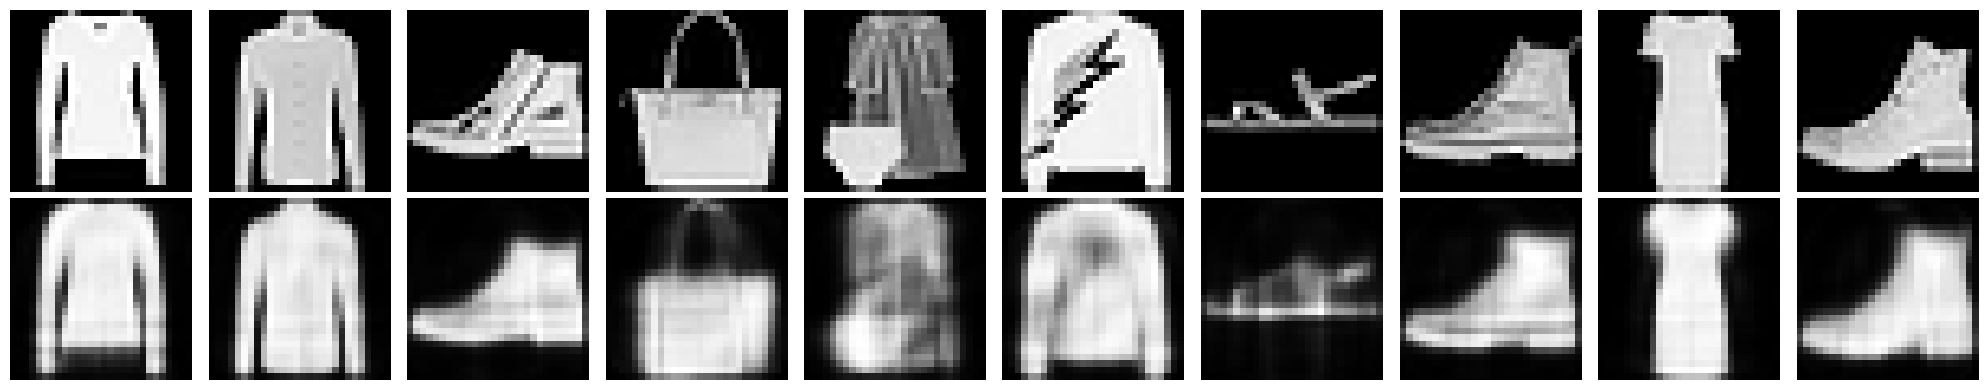

In [ ]:
# Dimensão de entrada e latente
input_dim = 28*28
latent_dim = 100  # Tamanho com melhor resultado

# =======================
# 1) Inicializar pesos
# =======================

def init_weights(in_dim, out_dim):
    return np.random.randn(in_dim, out_dim) * 0.01, np.zeros(out_dim)

# Encoder: input_dim -> latent_dim
W_enc, b_enc = init_weights(input_dim, latent_dim)

# Decoder: latent_dim -> input_dim
W_dec, b_dec = init_weights(latent_dim, input_dim)

# =======================
# 2) Funções de ativação
# =======================

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)

def mse_loss(x, x_hat):
    return np.mean((x - x_hat)**2)

def mse_grad(x, x_hat):
    return 2 * (x_hat - x) / x.shape[0]

# =======================
# 3) Forward pass
# =======================

def forward(x, W_enc, b_enc, W_dec, b_dec):
    # Encoder
    z_lin = np.dot(x, W_enc) + b_enc
    z = sigmoid(z_lin)  # ativação latente

    # Decoder
    x_hat_lin = np.dot(z, W_dec) + b_dec
    x_hat = sigmoid(x_hat_lin)  # saída entre 0 e 1
    return z, x_hat, z_lin, x_hat_lin

# =======================
# 4) Backpropagation
# =======================

def backward(x, z, x_hat, z_lin, x_hat_lin,
             W_enc, b_enc, W_dec, b_dec, lr=0.1):

    # Gradiente da saída (decoder)
    grad_out = mse_grad(x, x_hat) * sigmoid_deriv(x_hat_lin)
    dW_dec = np.dot(z.T, grad_out)
    db_dec = np.sum(grad_out, axis=0)

    # Gradiente da camada latente (encoder)
    grad_latent = np.dot(grad_out, W_dec.T) * sigmoid_deriv(z_lin)
    dW_enc = np.dot(x.T, grad_latent)
    db_enc = np.sum(grad_latent, axis=0)

    # Atualização dos pesos
    W_enc -= lr * dW_enc
    b_enc -= lr * db_enc
    W_dec -= lr * dW_dec
    b_dec -= lr * db_dec

    return W_enc, b_enc, W_dec, b_dec

# =======================
# 5) Treinamento
# =======================

epochs = 15
batch_size = 128
train_loss_history = []

for epoch in range(epochs):
    perm = np.random.permutation(len(x_train))
    x_train_shuffled = x_train[perm]

    for i in range(0, len(x_train), batch_size):
        x_batch = x_train_shuffled[i:i+batch_size]
        z, x_hat, z_lin, x_hat_lin = forward(x_batch, W_enc, b_enc, W_dec, b_dec)
        W_enc, b_enc, W_dec, b_dec = backward(x_batch, z, x_hat, z_lin, x_hat_lin,
                                              W_enc, b_enc, W_dec, b_dec, lr=0.1)

    # Loss a cada época
    _, x_hat_full, z_lin, x_hat_lin = forward(x_train, W_enc, b_enc, W_dec, b_dec)
    loss = mse_loss(x_train, x_hat_full)
    train_loss_history.append(loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")


# =======================
# 6) Teste e visualização
# =======================

n = 10
idx = np.random.choice(len(x_test), n, replace=False)
samples = x_test[idx]
np.save("selected_idx.npy", idx)

z, recons, _, _ = forward(samples, W_enc, b_enc, W_dec, b_dec)

plt.figure(figsize=(2*n, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(samples[i].reshape(28,28), cmap="gray")
    plt.axis("off")
    # Reconstruída
    ax = plt.subplot(2, n, n+i+1)
    plt.imshow(recons[i].reshape(28,28), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()


# Plot da curva de erro



1.  **Queda inicial acentuada (épocas 0 → 3)**

* Isso mostra que o modelo aprendeu padrões básicos das imagens já nas primeiras épocas (estruturas gerais como bordas, formas simples, contraste).

2. **Treinamento estável (épocas 3 → 10)**

* A perda continua caindo, mas de forma mais lenta.

* Pequenas oscilações (ex.: na época 7)

3. **Estabilização (épocas 10 → 14)**

* Isso indica que mais épocas não trariam ganhos significativos, o modelo já
atingiu um bom equilíbrio entre reconstrução e complexidade.




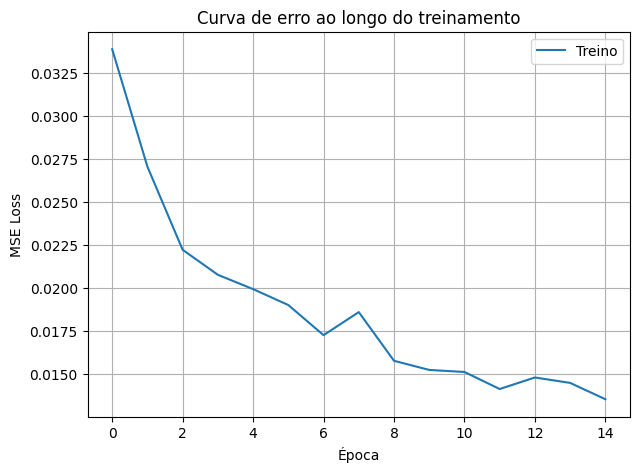

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(train_loss_history, label="Treino")
plt.xlabel("Época")
plt.ylabel("MSE Loss")
plt.title("Curva de erro ao longo do treinamento")
plt.grid(True)
plt.legend()
plt.show()

# Conclusão



*   O modelo captura a forma geral e os contornos principais das roupas.

*   Há uma perda de detalhes finos (textura, costura, padrões pequenos), o que é esperado, já que o autoencoder aprende uma representação comprimida.

*   Mesmo sem rótulos, o modelo consegue preservar as características essenciais para reconhecer a categoria da peça.


